<a href="https://colab.research.google.com/github/namrahrehman/research/blob/main/Copy_of_DINO_LORA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers accelerate evaluate datasets peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 21.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12

In [ ]:
import transformers
import accelerate
import peft

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")

Transformers version: 4.41.2
Accelerate version: 0.32.1
PEFT version: 0.11.1


In [ ]:
from datasets import load_dataset

dataset = load_dataset("namrahrehman/Final_DR")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/546 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/554 [00:00<?, ? examples/s]

In [ ]:
# Assuming you want labels from the "train" split
labels = dataset["train"].features["label"].names

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
  label2id[label] = i
  id2label[i] = label

id2label[2]

'2'

In [ ]:
from collections import Counter

# Count the occurrences of each class label in the train split
train_class_counts = Counter(dataset['train']['label'])

# Print the distribution of classes in the train split
print("Distribution of classes in the train split:")
for label, count in train_class_counts.items():
    print(f"Class {label}: {count} samples")

from collections import Counter

# Count the occurrences of each class label in the train split
val_class_counts = Counter(dataset['validation']['label'])

# Print the distribution of classes in the train split
print("Distribution of classes in the val split:")
for label, count in val_class_counts.items():
    print(f"Class {label}: {count} samples")

from collections import Counter

# Count the occurrences of each class label in the train split
test_class_counts = Counter(dataset['test']['label'])

# Print the distribution of classes in the train split
print("Distribution of classes in the test split:")
for label, count in test_class_counts.items():
    print(f"Class {label}: {count} samples")

Distribution of classes in the train split:
Class 0: 19385 samples
Class 1: 2702 samples
Class 2: 5991 samples
Class 3: 1008 samples
Class 4: 914 samples
Distribution of classes in the val split:
Class 0: 270 samples
Class 1: 55 samples
Class 2: 149 samples
Class 3: 28 samples
Class 4: 44 samples
Distribution of classes in the test split:
Class 0: 272 samples
Class 1: 56 samples
Class 2: 151 samples
Class 3: 30 samples
Class 4: 45 samples


In [ ]:
#@title Original Transforms
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    Resize,
    ToTensor,
    InterpolationMode
)


# Define transformation parameters
resize_size: int = 256
interpolation = InterpolationMode.BICUBIC
crop_size: int = 224


# Create the normalization transform
normalize = Normalize(mean=[0.5040619, 0.50250248, 0.50190439], std=[0.07344166, 0.08586248, 0.05501917])

# Define the transformations
def create_transforms():
    return Compose([
        Resize(resize_size, interpolation=interpolation),
        CenterCrop(crop_size),
        ToTensor(),
        normalize,
    ])

# Create transformation pipelines for training and validation
train_transforms = create_transforms()
val_transforms = create_transforms()

def preprocess_batch(example_batch, transforms):
    """Apply the given transforms across a batch of images."""
    example_batch["pixel_values"] = [transforms(image) for image in example_batch["image"]]
    return example_batch

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    return preprocess_batch(example_batch, train_transforms)

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    return preprocess_batch(example_batch, val_transforms)


In [ ]:
train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_val)

# Example usage of the splits
print(train_ds)
print(val_ds)
print(test_ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 30000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 546
})
Dataset({
    features: ['image', 'label'],
    num_rows: 554
})


In [ ]:
model_checkpoint = 'facebook/dinov2-base'

In [ ]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print_trainable_parameters(model)

trainable params: 86748349 || all params: 86748349 || trainable%: 100.00


In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value", "key", "classifier"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 582661 || all params: 87331010 || trainable%: 0.67


In [ ]:
lora_model.eval()

PeftModel(
  (base_model): LoraModel(
    (model): Dinov2ForImageClassification(
      (dinov2): Dinov2Model(
        (embeddings): Dinov2Embeddings(
          (patch_embeddings): Dinov2PatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): Dinov2Encoder(
          (layer): ModuleList(
            (0-11): 12 x Dinov2Layer(
              (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
              (attention): Dinov2Attention(
                (attention): Dinov2SelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_feature

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback


model_name = model_checkpoint.split("/")[-1]
batch_size = 64

args = TrainingArguments(
    f"dinov2-base-finetuned-lora-rank8",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=16,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=20,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    push_to_hub=True,
    label_names=["labels"],
    lr_scheduler_type="cosine"
)

In [ ]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
import torch


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of evaluations with no improvement
    early_stopping_threshold=0.005  # Minimal improvement to qualify as an improvement
)

In [ ]:
import numpy as np
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    callbacks=[early_stopping_callback]
)
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,1.064600,1.026770,0.699634
1,0.891400,0.719209,0.752747
2,0.791500,0.693789,0.743590
3,0.755900,0.653460,0.747253
4,0.727700,0.586404,0.782051
5,0.706600,0.588882,0.774725
6,0.679100,0.565098,0.782051
7,0.662600,0.558111,0.793040
8,0.665500,0.530742,0.805861
9,0.655100,0.514611,0.813187


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize

In [ ]:
prediction_output = trainer.predict(test_ds)
predictions = prediction_output.predictions
label_ids = prediction_output.label_ids
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score,cohen_kappa_score
from sklearn.preprocessing import label_binarize

accuracy = accuracy_score(label_ids, predicted_labels)
balanced_accuracy = balanced_accuracy_score(label_ids, predicted_labels)
precision = precision_score(label_ids, predicted_labels, average='weighted')
recall = recall_score(label_ids, predicted_labels, average='weighted')
f1 = f1_score(label_ids, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(label_ids, predicted_labels)
tn = np.diag(cm)
fp = cm.sum(axis=0) - tn
tn_sum = cm.sum() - cm.sum(axis=0) - cm.sum(axis=1) + tn.sum()
specificity = specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

  # Reshape to remove unnecessary dimension
print(f"Specificity (Overall): {specificity:.4f}")


# Binarize the labels for multi-class ROC AUC
labels_binarized = label_binarize(label_ids, classes=np.unique(label_ids))
# Assuming 'predictions' are probabilities for each class
roc_auc = roc_auc_score(labels_binarized, predictions, multi_class='ovr', average='weighted')
print(f"ROC AUC Score: {roc_auc:.4f}")

kappa = cohen_kappa_score(label_ids, predicted_labels)
print(f"Kappa Score: {kappa:.4f}")

print(cm)

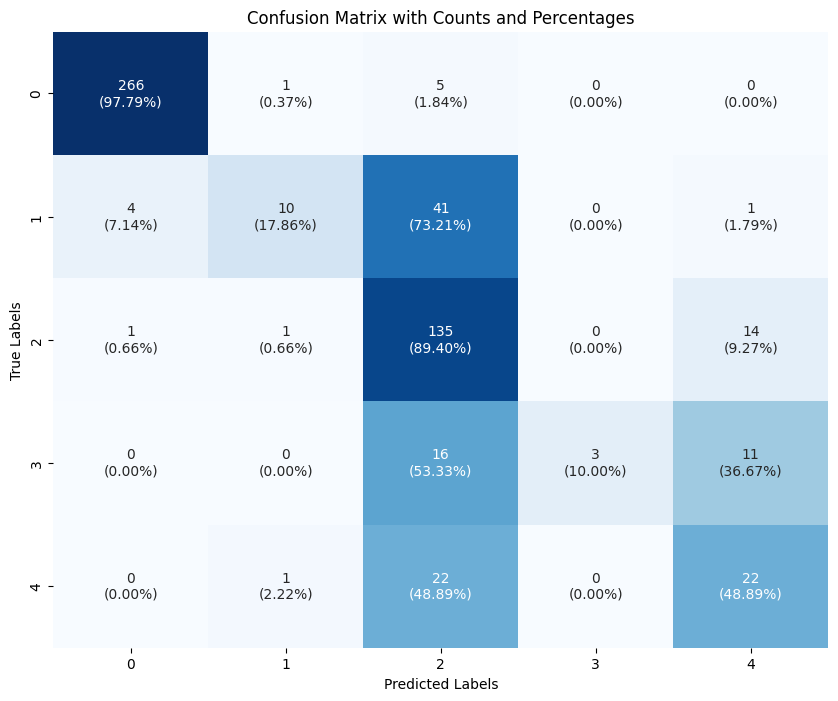

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
tf_cifar10_labels = ['0','1','2','3','4']
# Compute the confusion matrix
cm = confusion_matrix(label_ids, predicted_labels)

# Normalize the confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a combined matrix for display
combined_matrix = np.array(["{0}\n({1:.2f}%)".format(value, percent*100)
                            for value, percent in zip(cm.flatten(), cm_normalized.flatten())]).reshape(cm.shape)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=combined_matrix, fmt='', cmap="Blues", cbar=False,
            xticklabels=tf_cifar10_labels, yticklabels=tf_cifar10_labels)
plt.title("Confusion Matrix with Counts and Percentages")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
report = classification_report(label_ids, predicted_labels)
print(report)

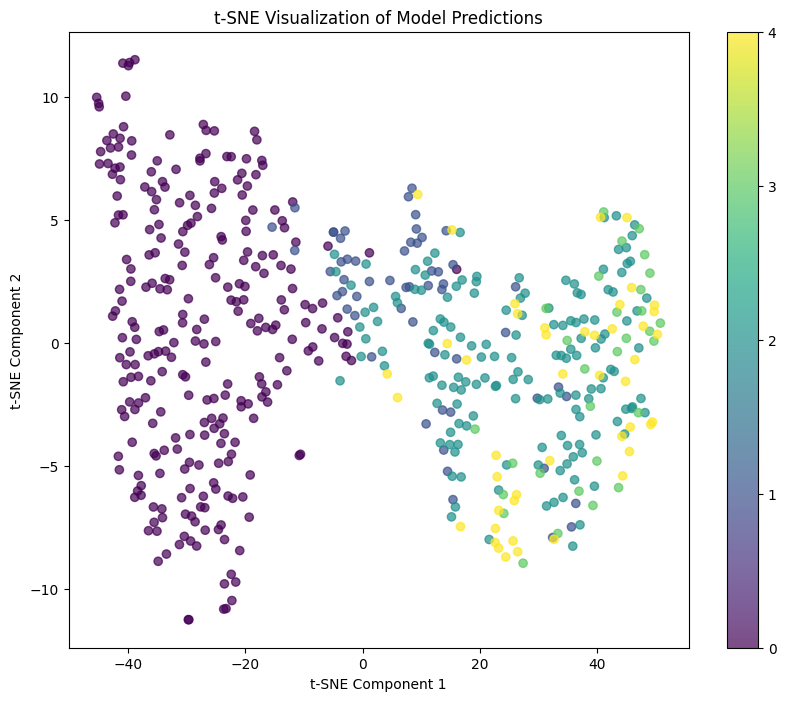

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE to the prediction logits/probabilities
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(predictions)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=label_ids, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ticks=np.arange(len(set(label_ids))))
plt.title("t-SNE Visualization of Model Predictions")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()